# GPN Intelligence CUP
## Продвинутая аналитика

### Выполнил Никифоров Глеб Владиславович

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Читаем данные

In [3]:
customers = pd.read_csv('customers.tsv', sep='\t')
sales = pd.read_csv('sales.tsv', sep='\t')

In [4]:
customers.head(3)

,year,month,ira,customers_type,amount_of_customers
0,2017,1,AC,Archer,679.0
1,2017,1,AC,Monk,1070.0
2,2017,1,AC,Dwarf,610.0


In [5]:
sales.head(3)

,year,month,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price
0,2017,1,Alpha City,AC,Chocolates,Cadbury,sku #79,1,Standart,No,Nothing,4572.0,NaN
1,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #15,1,Standart,No,Nothing,8028.0,1.221336
2,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #16,3,Standart,No,Nothing,6606.0,2.866401


Выкинем из sales колонку location, так как она дублирует колонку ira.

In [6]:
sales = sales.drop(columns=['location'])

## 1. Предварительный анализ данных

Проверим наличие пропущенных значений

In [7]:
null_number = sales.isnull().sum()
null_number[null_number!=0]

price    112
dtype: int64

In [8]:
null_number = customers.isnull().sum()
null_number[null_number!=0]

Series([], dtype: int64)

#### Вместо года и месяца будем использовать номер месяца считая от января 2017.

In [9]:
customers['month_n'] = (customers.year - 2017) * 12 + customers.month
sales['month_n'] = (sales.year - 2017) * 12 + sales.month

#### Проверим, есть ли товары, которые в июне 2019 уже не продаются

In [10]:
out_of_sale = frozenset(sales.sku_id.unique()) - frozenset(sales[sales.month_n == 30].sku_id.unique())
out_of_sale

frozenset({'sku #11',
           'sku #17',
           'sku #27',
           'sku #3',
           'sku #33',
           'sku #34',
           'sku #37',
           'sku #43',
           'sku #44',
           'sku #5',
           'sku #55',
           'sku #60',
           'sku #7',
           'sku #72',
           'sku #81',
           'sku #82',
           'sku #83',
           'sku #84',
           'sku #98'})

Логично предположить, что и дальше эти товары продаваться не будут, и предсказание для них делать бессмысленно.

In [11]:
sales.sku_id.nunique()

43

#### Проверим также, какие товары в последний месяц продавались не во всех регионах.

In [12]:
sales_check = sales[sales.month_n == 30].pivot_table(index='sku_id',
                                columns='ira',
                                values='month_n',
                                aggfunc='count',
                                fill_value=0).reset_index()
sales_check

ira,sku_id,AC,MN,PB,VL
0,sku #100,1,1,1,0
1,sku #105,0,0,1,0
2,sku #106,1,0,1,0
3,sku #15,1,0,1,0
4,sku #16,1,1,1,0
5,sku #22,1,1,1,0
6,sku #25,1,1,1,1
7,sku #28,1,1,1,0
8,sku #30,1,1,1,1
9,sku #31,1,0,0,0


#### Заметим так же, что информация о клиентах представленна только в трех географических зонах, а о продажах - в четырех.
Зона VL вообще не иформативна, поэтому предсказание для нее делать не будем.

In [13]:
sales.ira.unique()

array(['AC', 'MN', 'PB', 'VL'], dtype=object)

In [14]:
customers.ira.unique()

array(['AC', 'MN', 'PB'], dtype=object)

Для остальных товаров логично предположить, что если они не продавались в июне 2019 г. в каком-то географическом регионе, то они и дальше не будут там продаваться.
### Итоги предварительной аналитики:
* Не будем деать предсказания для товаов, которые не продавались в июне 2019 г. *(список out_of_sales)*, так как они и дальше вероятнее всего не будут продаваться. **(можно считать, что предсказывается значение 0)**
* Не будем деать предсказания для геогрфической зоны VL, так как по ней нет информации о клиентах и товаров в июне 2019 г. продавалось мало.
* Не будем деать предсказания для пар (товар; географический регион), которые имеют ноль в тблице sales_check, так как данные товары не продвались в этих географических регионах в июне 2019 г. и вероятнее всего не будут продаваться в будущем. **(можно считать, что предсказывается значение 0)**

## 2. Подготовка тренировочного датасета
#### В итоговом датасете хочется иметь как информацию о продажах, так и информацию о клиентах.
Для этого введем у customers и sales фиктивную величину, по которой эти таблицы позже будут объеденены.

In [15]:
sales = sales[sales.ira != 'VL']

In [16]:
customers['month_n_ira'] = customers.month_n.map(str) + '_' + customers.ira.map(str)
sales['month_n_ira'] = sales.month_n.map(str) + '_' + sales.ira.map(str)

In [17]:
customers.tail(3)

,year,month,ira,customers_type,amount_of_customers,month_n,month_n_ira
1977,2019,9,PB,Elf,2477.0,33,33_PB
1978,2019,9,PB,Angel,1355.0,33,33_PB
1979,2019,9,PB,other,8062.0,33,33_PB


In [18]:
sales.tail(3)

,year,month,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,month_n,month_n_ira
1722,2019,6,PB,Lollipops,Chupa Chups,sku #76,1,Round,Yes,Nuts,3882.0,1.316449,30,30_PB
1723,2019,6,PB,Lollipops,Chupa Chups,sku #77,1,Round,No,Nuts,3834.0,1.316449,30,30_PB
1724,2019,6,PB,Lollipops,Chupa Chups,sku #97,1,Round,No,Nuts,5790.0,1.316449,30,30_PB


Выбросим из customers информацию за 7, 8 и 9 месяцы 2019г. и дропнем лишние столбцы.

In [19]:
customers_train = customers[customers.month_n < 31].drop(columns=['year', 'month'])

In [20]:
customers_train.tail(3)

,ira,customers_type,amount_of_customers,month_n,month_n_ira
1917,PB,Elf,2648.0,30,30_PB
1918,PB,Angel,1477.0,30,30_PB
1919,PB,other,6831.0,30,30_PB


Развернем информацию о клиентах.

In [21]:
customers_data_train = customers_train.pivot_table(index='month_n_ira',
                                                   columns='customers_type',
                                                   values='amount_of_customers').reset_index()

In [22]:
customers_data_train.head(3)

customers_type,month_n_ira,Angel,Archer,Centaur,Demon,Dwarf,Elf,Gargoyle,Genie,Ghost,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
0,10_AC,1158.0,852.0,2392.0,1255.0,782.0,6304.0,1692.0,8081.0,1308.0,...,698.0,2001.0,567.0,341.0,1085.0,1938.0,1144.0,40221.0,3143.0,11060.0
1,10_MN,717.0,72.0,138.0,64.0,60.0,1142.0,358.0,1055.0,297.0,...,212.0,613.0,314.0,59.0,76.0,87.0,234.0,14244.0,1168.0,1951.0
2,10_PB,1215.0,178.0,909.0,251.0,244.0,2000.0,812.0,1319.0,598.0,...,521.0,8639.0,471.0,958.0,304.0,908.0,660.0,15619.0,1889.0,6158.0


#### Произведем объединение по фиктивной величине

In [23]:
sales_data_train = sales.merge(customers_data_train, on='month_n_ira', how='inner').\
    drop(columns=['month_n_ira', 'year', 'month'])

In [24]:
sales_data_train.tail(3)

,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
1691,PB,Lollipops,Chupa Chups,sku #76,1,Round,Yes,Nuts,3882.0,1.316449,...,546.0,9222.0,475.0,1145.0,343.0,933.0,718.0,16501.0,2084.0,6831.0
1692,PB,Lollipops,Chupa Chups,sku #77,1,Round,No,Nuts,3834.0,1.316449,...,546.0,9222.0,475.0,1145.0,343.0,933.0,718.0,16501.0,2084.0,6831.0
1693,PB,Lollipops,Chupa Chups,sku #97,1,Round,No,Nuts,5790.0,1.316449,...,546.0,9222.0,475.0,1145.0,343.0,933.0,718.0,16501.0,2084.0,6831.0


Заметим что, количество строк в получившемся датасете совпадает с количеством строк в датасете sales, а также не появилось новых пустых значений. Значит объединение прошло успешно.

In [25]:
sales.shape[0] == sales_data_train.shape[0]

True

In [26]:
null_number = sales_data_train.isnull().sum()
null_number[null_number!=0]

price    112
dtype: int64

## 3. Подготовка предиктового датасета

Как уже говорилось ранее: предсказание будем делать только для тех товаров, которые продолжают продаваться на июнь 2019 г. (и только в регионах, в которых они продаются)

In [27]:
sales_last_month = sales[sales.month_n == 30].reset_index(drop=True).\
        drop(columns=['year', 'month', 'month_n', 'month_n_ira'])

In [28]:
sales_last_month.tail(3)

,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price
55,PB,Lollipops,Chupa Chups,sku #76,1,Round,Yes,Nuts,3882.0,1.316449
56,PB,Lollipops,Chupa Chups,sku #77,1,Round,No,Nuts,3834.0,1.316449
57,PB,Lollipops,Chupa Chups,sku #97,1,Round,No,Nuts,5790.0,1.316449


In [29]:
sales_last_month.isnull().sum()

ira                 0
product_category    0
brand               0
sku_id              0
item_per_bundle     0
shape               0
with_alcohol        0
filling             0
volume              0
price               0
dtype: int64

In [30]:
sales_to_pred = pd.DataFrame()
for i in range(31, 34):
    sales_last_month['month_n'] = i
    sales_last_month['volume'] = np.NaN
    sales_to_pred = sales_to_pred.append(sales_last_month).reset_index(drop=True)

In [31]:
sales_to_pred.tail(3)

,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,month_n
171,PB,Lollipops,Chupa Chups,sku #76,1,Round,Yes,Nuts,NaN,1.316449,33
172,PB,Lollipops,Chupa Chups,sku #77,1,Round,No,Nuts,NaN,1.316449,33
173,PB,Lollipops,Chupa Chups,sku #97,1,Round,No,Nuts,NaN,1.316449,33


In [32]:
sales_to_pred.shape[0] == 3 * sales_last_month.shape[0]

True

In [33]:
null_number = sales_to_pred.isnull().sum()
null_number[null_number!=0]

volume    174
dtype: int64

Добавили к продажам номер месяца и:
* количество строк увеличилось втрое, как и должно
* не появились пустые значения, кроме volume, который мы собираемся предсказывать 

значит все прошло успешно.

In [34]:
sales_to_pred['month_n_ira'] = sales_to_pred.month_n.map(str) + '_' + sales_to_pred.ira.map(str)

In [35]:
customers_to_pred = customers[customers.month_n > 30].drop(columns=['year', 'month'])

In [36]:
customers_data_to_pred = customers_to_pred.pivot_table(index='month_n_ira',
                                                   columns='customers_type',
                                                   values='amount_of_customers').reset_index()

In [37]:
sales_data_to_pred = sales_to_pred.merge(customers_data_to_pred, on='month_n_ira', how='inner').\
    drop(columns=['month_n_ira'])

In [38]:
sales_data_to_pred.tail(3)

,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
171,PB,Lollipops,Chupa Chups,sku #76,1,Round,Yes,Nuts,NaN,1.316449,...,534.0,8976.0,540.0,1066.0,334.0,948.0,798.0,15752.0,1896.0,8062.0
172,PB,Lollipops,Chupa Chups,sku #77,1,Round,No,Nuts,NaN,1.316449,...,534.0,8976.0,540.0,1066.0,334.0,948.0,798.0,15752.0,1896.0,8062.0
173,PB,Lollipops,Chupa Chups,sku #97,1,Round,No,Nuts,NaN,1.316449,...,534.0,8976.0,540.0,1066.0,334.0,948.0,798.0,15752.0,1896.0,8062.0


In [39]:
sales_to_pred.shape[0] == sales_data_to_pred.shape[0]

True

In [40]:
null_number = sales_data_to_pred.isnull().sum()
null_number[null_number!=0]

volume    174
dtype: int64

* количество строк не изменилось
* пустые значения не появились 

значит merge прошел успешно.

## 4. Кодировка и масштабирование данных

Необходимо теперь закодировать категориальные переменные и отмасштабировать количественные.

Масштабирование количественных переменных будем проводить заменяя их на их z-значения, где

$z = \frac{X - MX}{stdX}$

Чтобы кодировка и масштабирование было общим для тренировочного и предиктового датасетов объединим их в один.

In [41]:
all_data = sales_data_train.append(sales_data_to_pred).reset_index(drop=True)

In [42]:
volume_mean = all_data.volume.mean()
volume_std = all_data.volume.std()

price_mean = all_data.price.mean()
price_std = all_data.price.std()

numeric_values = ''
category_values = ''
category_dictionary = {}
for i in all_data.drop(columns=['month_n']):
    if (all_data[i].dtype == int or all_data[i].dtype == float) and all_data[i].nunique() > 33:
        all_data[i] = (all_data[i] - all_data[i].mean()) / all_data[i].std()
        numeric_values += i + '; '
    else:
        categorized = all_data[i].astype('category')
        category_dictionary[i] = tuple(categorized.cat.categories)
        categorized = categorized.cat.codes
        all_data[i] = categorized
        category_values += i + '; '

In [43]:
numeric_values

'volume; price; Angel; Archer; Centaur; Demon; Dwarf; Elf; Gargoyle; Genie; Ghost; Giant; Goblin; Gremlin; Medusa; Minotaur; Monk; Orc; Pegasus; Pirate; Unicorn; other; '

In [44]:
category_values

'ira; product_category; brand; sku_id; item_per_bundle; shape; with_alcohol; filling; '

In [45]:
all_data.tail(3)

,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
1865,2,1,1,32,0,0,1,2,NaN,-0.439421,...,0.254989,1.382126,0.259308,1.411236,-0.476553,-0.407115,-0.018658,-0.503645,-0.255551,0.219432
1866,2,1,1,33,0,0,0,2,NaN,-0.439421,...,0.254989,1.382126,0.259308,1.411236,-0.476553,-0.407115,-0.018658,-0.503645,-0.255551,0.219432
1867,2,1,1,41,0,0,0,2,NaN,-0.439421,...,0.254989,1.382126,0.259308,1.411236,-0.476553,-0.407115,-0.018658,-0.503645,-0.255551,0.219432


In [46]:
category_dictionary

{'ira': ('AC', 'MN', 'PB'),
 'product_category': ('Chocolates', 'Lollipops'),
 'brand': ('Cadbury',
  'Chupa Chups',
  'Ferrero Rocher',
  'Milka',
  'Snickers',
  'Toblerone',
  'Twix'),
 'sku_id': ('sku #100',
  'sku #105',
  'sku #106',
  'sku #11',
  'sku #15',
  'sku #16',
  'sku #17',
  'sku #22',
  'sku #25',
  'sku #27',
  'sku #28',
  'sku #3',
  'sku #30',
  'sku #31',
  'sku #33',
  'sku #34',
  'sku #37',
  'sku #38',
  'sku #41',
  'sku #42',
  'sku #43',
  'sku #44',
  'sku #46',
  'sku #48',
  'sku #49',
  'sku #5',
  'sku #55',
  'sku #60',
  'sku #67',
  'sku #7',
  'sku #72',
  'sku #73',
  'sku #76',
  'sku #77',
  'sku #78',
  'sku #79',
  'sku #81',
  'sku #82',
  'sku #83',
  'sku #84',
  'sku #94',
  'sku #97',
  'sku #98'),
 'item_per_bundle': (1, 2, 3),
 'shape': ('Round', 'Square', 'Standart'),
 'with_alcohol': ('No', 'Yes'),
 'filling': ('Berries', 'Nothing', 'Nuts')}

In [47]:
train_data = all_data[all_data.month_n <= 30]
prediction_data = all_data[all_data.month_n > 30]

## 5. Восстановление пропущенных значений цен в тренировочном датасете

Посмотрим, как пропущенные значения цен распределены по месяцам.

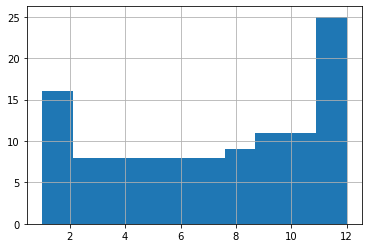

In [48]:
train_data[train_data.price.isnull()].month_n.hist()

Видно, что пропущенные цены имеются только в 2017 году.

Посмотрим как цена товара в регионе зависит от номера месяца.
(Ограничимся тремя случайными товарами)
Если зависимости окажутся линейными, цены можно будет восстановить используя линейную регрессию для каждого товара в каждом регионе.

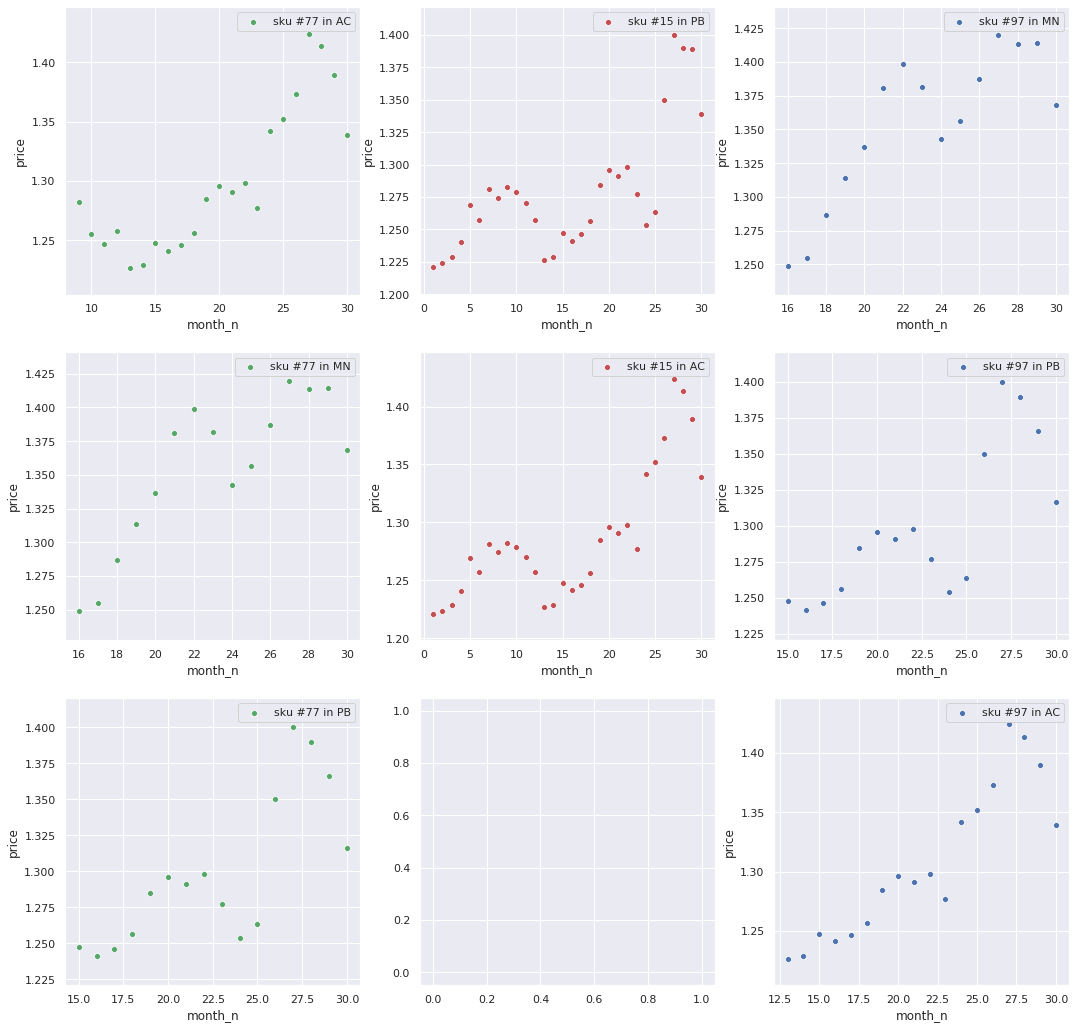

In [49]:
sns.set(rc={'figure.figsize': (18, 18)})
fig, ax = plt.subplots(3,3)

"""Первая строка"""
sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #77') & (sales_data_train.ira == 'AC')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #77') & (sales_data_train.ira == 'AC')].price,
              color="g", ax=ax[0, 0], label='sku #77 in AC')

sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #15') & (sales_data_train.ira == 'PB')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #15') & (sales_data_train.ira == 'PB')].price,
              color="r", ax=ax[0, 1], label='sku #15 in PB')

sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #97') & (sales_data_train.ira == 'MN')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #97') & (sales_data_train.ira == 'MN')].price,
              color="b", ax=ax[0, 2], label='sku #97 in MN')

"""Вторая строка"""
sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #77') & (sales_data_train.ira == 'MN')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #77') & (sales_data_train.ira == 'MN')].price,
              color="g", ax=ax[1, 0], label='sku #77 in MN')

sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #15') & (sales_data_train.ira == 'AC')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #15') & (sales_data_train.ira == 'AC')].price,
              color="r", ax=ax[1, 1], label='sku #15 in AC')

sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #97') & (sales_data_train.ira == 'PB')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #97') & (sales_data_train.ira == 'PB')].price,
              color="b", ax=ax[1, 2], label='sku #97 in PB')

"""Третья строка"""
sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #77') & (sales_data_train.ira == 'PB')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #77') & (sales_data_train.ira == 'PB')].price,
              color="g", ax=ax[2, 0], label='sku #77 in PB')

sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #15') & (sales_data_train.ira == 'MN')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #15') & (sales_data_train.ira == 'MN')].price,
              color="r", ax=ax[2, 1], label='sku #15 in MN')

sns.scatterplot(sales_data_train[(sales_data_train.sku_id == 'sku #97') & (sales_data_train.ira == 'AC')].month_n,
              sales_data_train[(sales_data_train.sku_id == 'sku #97') & (sales_data_train.ira == 'AC')].price,
              color="b", ax=ax[2, 2], label='sku #97 in AC')

К сожалению, зависимости не линейные, и простой линейной регрессией восползоваться не удастся.

Воспользуемся регрессоом из библиотеки **XGboost**, хорошо зарекомендовавшим себя на других похожих задачах.
(В моем опыте решения задач на Kaggle модели из этой библиотеки неизменно превосходят остальные модели по большинству метрик) 

In [50]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Подготовим данные для тренировки и пресказания

In [51]:
train_data.head(3)

,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
0,0,0,0,35,0,2,0,1,0.300544,NaN,...,-0.510078,-0.710419,-0.323837,-0.682747,1.033682,1.417077,0.5764,-0.342145,0.645922,0.346924
1,0,0,2,4,0,2,0,1,1.294830,-0.587805,...,-0.510078,-0.710419,-0.323837,-0.682747,1.033682,1.417077,0.5764,-0.342145,0.645922,0.346924
2,0,0,2,5,2,2,0,1,0.885723,1.978626,...,-0.510078,-0.710419,-0.323837,-0.682747,1.033682,1.417077,0.5764,-0.342145,0.645922,0.346924


In [52]:
data_to_pred_price_train = train_data[train_data.price.notnull()]

In [53]:
null_number = data_to_pred_price_train.isnull().sum()
null_number[null_number!=0]

Series([], dtype: int64)

In [54]:
data_to_pred_price_train.shape

(1582, 31)

In [55]:
data_to_pred_price = train_data[train_data.price.isnull()]

In [56]:
null_number = data_to_pred_price.isnull().sum()
null_number[null_number!=0]

price    112
dtype: int64

In [57]:
data_to_pred_price.shape

(112, 31)

In [58]:
y = data_to_pred_price_train.price
X = data_to_pred_price_train.drop(columns=['price'])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [60]:
X_to_pred = data_to_pred_price.drop(columns=['price'])

**Подготовим и обучим модель**

In [61]:
regr = xgb.XGBRegressor()

In [62]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.6, 0.9],
              'verbosity': range(0, 4),
              'booster': ['gbtree', 'dart'],
              'max_depth': range(4, 15), 'min_samples_split': range(10, 300, 15),
              'min_samples_leaf': range(10, 300, 10),
              'n_estimators': range(50, 500, 10)}

Следующий блок выполняется довольно долго, но в данном случае было решено, что точность играет наиболее важную роль. В противном случае можно уменьшить количество итераций или варьируемых параметров.

In [63]:
rand_search_cv = RandomizedSearchCV(regr, parameters, cv=5, scoring='neg_mean_absolute_error',
                                    n_iter=50, n_jobs=-1, random_state=0)

In [64]:
rand_search_cv.fit(X_train, y_train)

/home/gleb/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:37:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                   param_distributions={'booster': ['gbtree', 'dart'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3,
                                      

In [65]:
rand_search_cv.best_params_

{'verbosity': 1,
 'n_estimators': 360,
 'min_samples_split': 100,
 'min_samples_leaf': 70,
 'max_depth': 7,
 'learning_rate': 0.05,
 'booster': 'gbtree'}

In [66]:
xgb_best = rand_search_cv.best_estimator_

In [67]:
score = pd.DataFrame()
score['XGBRegression'] = [mean_squared_error(y_test,
                                                 xgb_best.predict(X_test)),
                             mean_absolute_error(y_test,
                                                 xgb_best.predict(X_test)),
                             r2_score(y_test,
                                      xgb_best.predict(X_test))]
score.index = ['MSE', 'MAE', 'R2']
score

,XGBRegression
MSE,0.000423
MAE,0.010969
R2,0.999545


Модель демонстрирует хорошую точность

**Восстановим пропущенные значения цен**

In [68]:
predicted_prices = xgb_best.predict(X_to_pred)

In [69]:
data_to_pred_price['price'] = predicted_prices

/home/gleb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
train_data = data_to_pred_price_train.append(data_to_pred_price).sort_index()

In [71]:
train_data.head(3)

,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
0,0,0,0,35,0,2,0,1,0.300544,-0.664089,...,-0.510078,-0.710419,-0.323837,-0.682747,1.033682,1.417077,0.5764,-0.342145,0.645922,0.346924
1,0,0,2,4,0,2,0,1,1.294830,-0.587805,...,-0.510078,-0.710419,-0.323837,-0.682747,1.033682,1.417077,0.5764,-0.342145,0.645922,0.346924
2,0,0,2,5,2,2,0,1,0.885723,1.978626,...,-0.510078,-0.710419,-0.323837,-0.682747,1.033682,1.417077,0.5764,-0.342145,0.645922,0.346924


In [72]:
train_data.shape

(1694, 31)

In [73]:
null_number = train_data.isnull().sum()
null_number[null_number!=0]

Series([], dtype: int64)

**Подготовка данных завершена, непосредственным решением задач займемся в другом ноутбуке**

In [74]:
train_data.to_csv('train_data.csv')
prediction_data.to_csv('prediction_data.csv')

Запомним следующие значения

In [75]:
volume_mean

3527.3506493506493

In [76]:
volume_std

3475.861595475336

In [77]:
price_mean

1.5981150052361002

In [78]:
price_std

0.6409932599958659